# CS:4440 - Web Mining 
# Homework 1

### Data Description

The source file respresents a network of Reddit users and their connections. Each row (source user) is deliminated by '|' and their column (linked users) is deliminated by ','.

In [9]:
# Imports
import csv
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt

### Dataset import and description

Reading in the dataset with columns 'source user' and 'linked users'.

In [2]:
# Read dataset
data = pd.read_csv('networkDataset_v2.psv',skiprows=1, sep = "|", index_col=False, 
                 names=['source user', 'linked users'])
data

,source user,linked users
0,frankEfurter,"IReadItOnReddit43,Mmiklase,erdbeerheld,owljay,..."
1,simplythrowmeaway,"larsskynyrd79,deathangel1217,linkenski,ValarM0..."
2,gmiz0,"berrythecat,alex23b,bluek00laid,Chaos_Therum,3..."
3,Frogtown_,"brokenpixel,TheCreepyDude,bluek00laid,gmiz0"
4,tinderhackflex,Liru
...,...,...
25297,optsyn,imro
25298,DJ_Skully,imro
25299,Zelda___Fitzgerald,imro
25300,Skinny128,imro


In [3]:
# Dimensions
print("Size:", data.size)
print("Shape:", data.shape)
print("Dimensions:", data.ndim)

Size: 50604
Shape: (25302, 2)
Dimensions: 2


### Dealing with multiple edges

Since each source user can have multiple linked users, the easiest way to make the data compatible with a graph library is to add separate the linked users into their own rows with the duplicated source user. 

In [4]:
# https://stackoverflow.com/questions/52804653/python-write-new-row-based-on-comma-separated-values-in-table-column
# Reindex and repeat cols on len of split and reset index
df1 = data.reindex(data.index.repeat(data['linked users'].fillna("").str.split(',').apply(len)))
df1 = df1.drop(['linked users'],1)

# Splitting both cols
s = data['linked users'].str.split(',', expand=True).stack().reset_index(level=1,drop=True)

# Now grouping the series and df using cumcount.
df1 = df1.set_index(df1.groupby(df1.index).cumcount(), append=True)
s = s.to_frame('linked users').set_index(s.groupby(s.index).cumcount(), append=True)

# Joining the all of them together and reset index.
df1 = df1.join(s, how='outer').reset_index(level=[0,1],drop=True)

df1

,source user,linked users
0,frankEfurter,IReadItOnReddit43
1,frankEfurter,Mmiklase
2,frankEfurter,erdbeerheld
3,frankEfurter,owljay
4,frankEfurter,Wooz122
...,...,...
56794,optsyn,imro
56795,DJ_Skully,imro
56796,Zelda___Fitzgerald,imro
56797,Skinny128,imro


### Using Networkx library to create a graph

In [5]:
# Using networkx to create a Graph
G = nx.Graph()

In [6]:
# Add nodes
nodes = data['source user']
G.add_nodes_from(nodes)

In [7]:
# Add edges
for i, row in df1.iterrows():
    G.add_edge(row['source user'], row['linked users'])

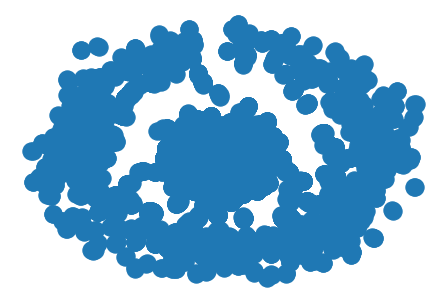

<Figure size 432x288 with 0 Axes>

In [13]:
# Draw graph
nx.draw(G)
plt.show()
plt.savefig("initial_graph.png")